# Image Classification of ATLAS Calorimeter Topo-Clusters

This notebook includes performance comparisons of different Machine Learning techniques for classifying topological clusters in the ATLAS calorimeter. 

### The task

Train a classifier to determine which type of particle generated the parton showers in the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeters. Normalized (per layer)( calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

1. Simple fully-connected Neural Network (flattening the images, developing a separate NN per calo layer).
2. Simple combinations (via a new NN, or combined single deep NN) of the flattened NNs from above.
3. Convolutional Neural Networks using only one layer (preserving the shape of the 2D images).
4. A network with multiple images as inputs, and one output (first couple of ConvNets are trained separately, then flattened and concatenated). 

TODO
- Cleanup code a bit, in particular make it easier to swap samples.
- Probably modify inputs to be just numpy arrays (rather than a dictionary of arrays), makes it easier to slice and dice inputs. 
- Implement a network of concatenated ConvNets taking all calorimeter layer images into account.
- Also compare the performance with other ML algorithms; logistic regression, SVD, Naive Bias, Gaussians, etc.


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plotpath = '/home/mfong/git/LCStudies/classifier/plots/'
modelpath = '/home/mfong/git/LCStudies/classifier/models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [2]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [3]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

import tensorflow as tf

# strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
strategy = tf.distribute.MirroredStrategy(devices=["/device:XLA_GPU:3"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"])
# strategy = tf.distribute.MirroredStrategy(devices=["/device:CPU:0","/device:XLA_GPU:3"],
#                       cross_device_ops=tf.contrib.distribute.AllReduceCrossDeviceOps(
#                          all_reduce_alg="hierarchical_copy"))
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:XLA_GPU:3',)
Number of devices: 1


## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

Run these before to create the `.npz` files:
```
python3 /home/mfong/git/LCStudies/util/mltree2array.py /data0/users/mfong/ML4Pions/v7/pi0.root --output /data0/users/mfong/ML4Pions/v7/pi0.npz -l 0 -c
python3 /home/mfong/git/LCStudies/util/mltree2array.py /data0/users/mfong/ML4Pions/v7/piplus.root --output /data0/users/mfong/ML4Pions/v7/piplus.npz -l 1 -c
python3 /home/mfong/git/LCStudies/util/mltree2array.py /data0/users/mfong/ML4Pions/v7/piminus.root --output /data0/users/mfong/ML4Pions/v7/piminus.npz -l -1 -c
```

In [4]:
# import pi+- vs. pi0 images

# seed = 10
# np.random.seed(seed)
path = '/data0/users/mfong/ML4Pions/v7/'
#path = '/eos/user/m/mswiatlo/images/'

# TODO fix input files so that it is easier to split up the events
p0 = np.load(path+"pi0.npz")
pp = np.load(path+"piplus.npz")
pm = np.load(path+"piminus.npz")

#clean up to round numbers, which are prefered by tf.keras
#don't actually need this
# p0d = {}
# p0d = {key:p0[key][:180000] for key in p0}
# # p0=p0d

# ppd = {}
# ppd = {key:pp[key][:180000] for key in pp}
# # pp=ppd

# pmd = {}
# pmd = {key:pm[key][:280000] for key in pm}
# pm=pmd

# pc = {}
#concat pp and pm for/ greater stats
# pc = {key:np.append(pp[key], pm[key], 0) for key in pp}
# pp = pc # naughty, just replace it so we don't have to change code later

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])
# npc = len(pc['EMB1'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
# print("Number of cpi events: {}".format(npc))
print("Total: {}".format(np0+npp+npm))

# print pp['label']
# print pm['label']
# print p0['label']

Number of pi0 events: 81543
Number of pi+ events: 82110
Number of pi- events: 81795
Total: 245448


### Plot a few example images

<Figure size 432x288 with 0 Axes>

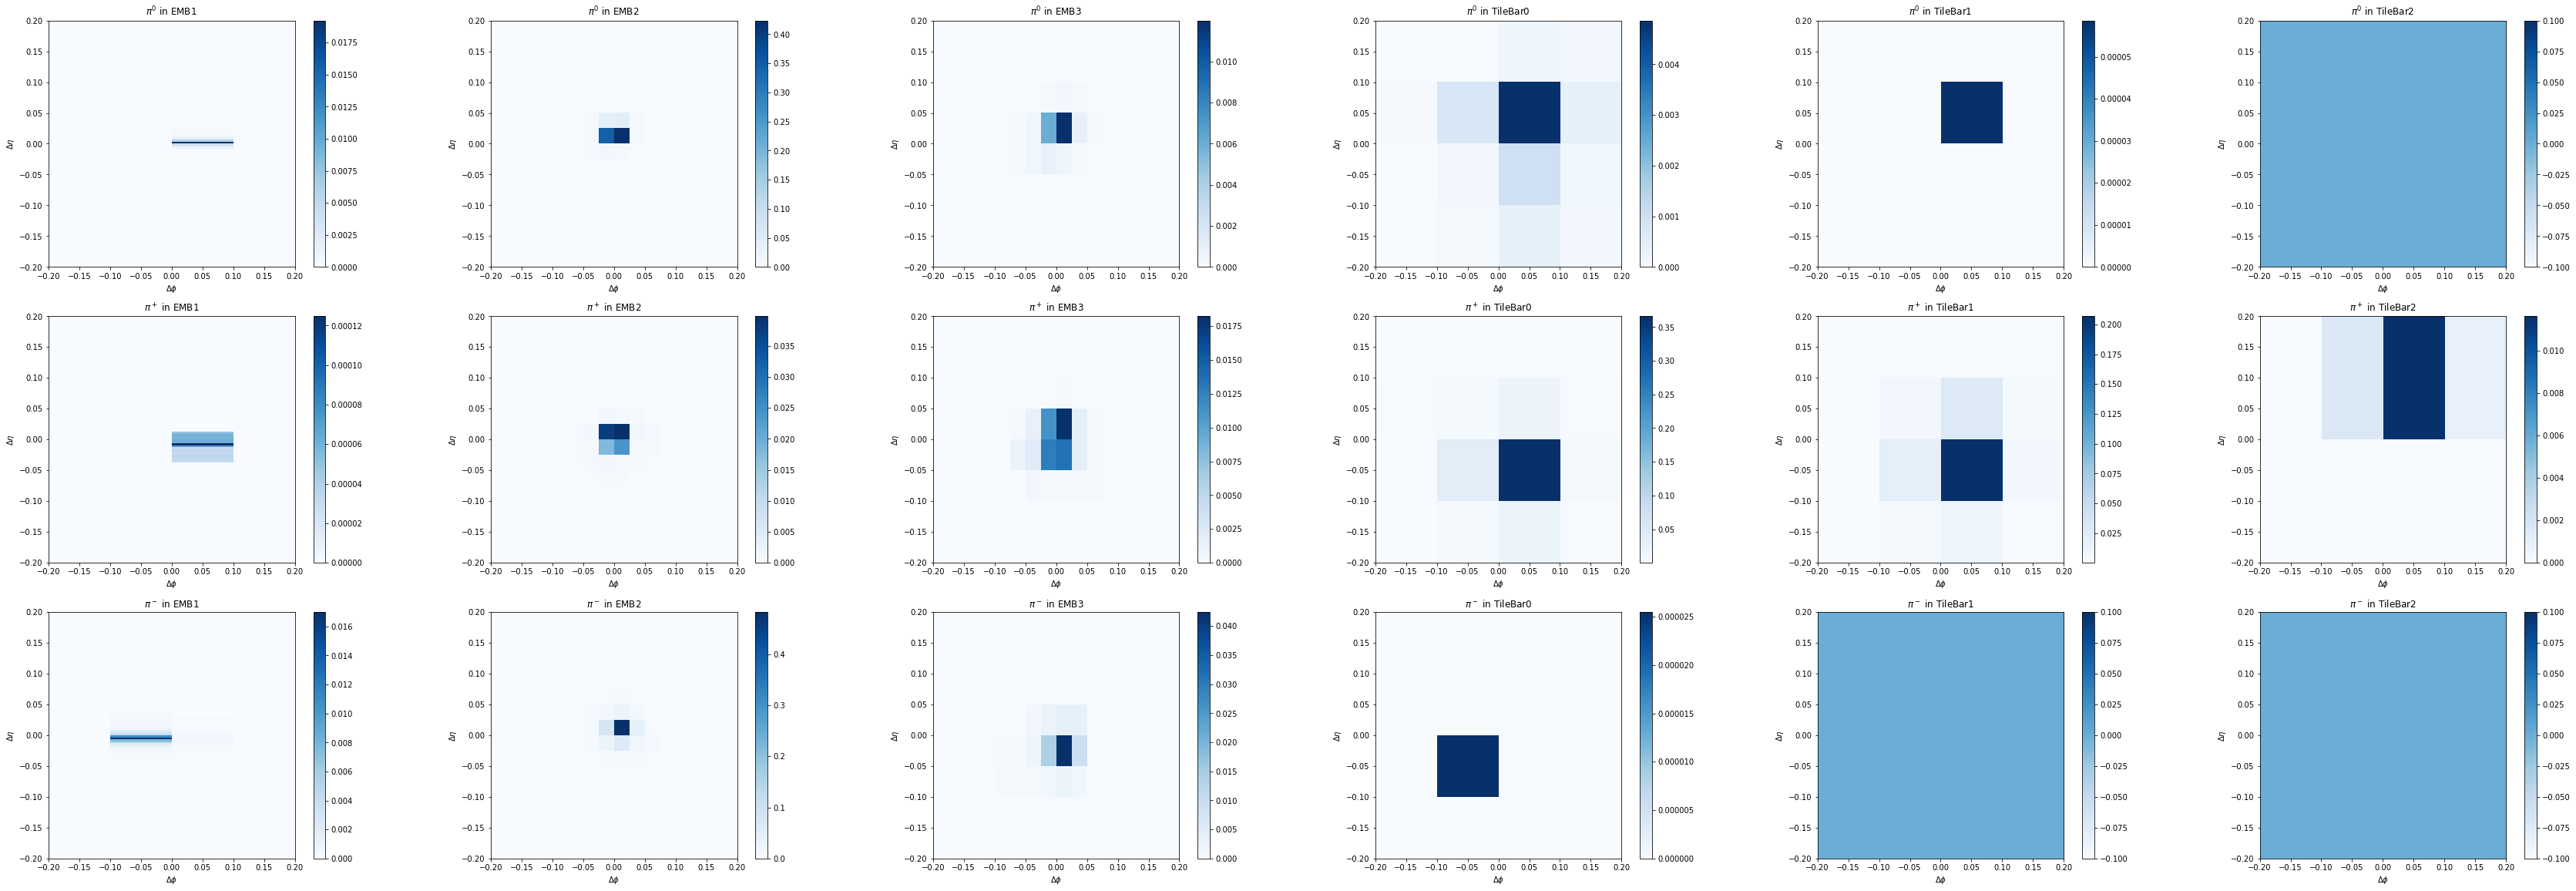

In [11]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 100

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(60,20))
fig.patch.set_facecolor('white')

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi+
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi-
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.savefig(plotpath + 'plots_pi0_plus_minus.pdf')
plt.show()


### Plot a few histograms

NameError: name 'pion' is not defined

<Figure size 432x288 with 0 Axes>

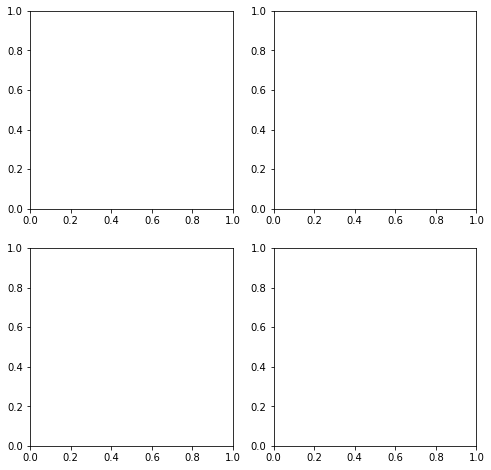

In [5]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, density=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, density=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, density=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, density=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, density=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, density=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, density=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, density=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pion_electron.pdf')

<Figure size 432x288 with 0 Axes>

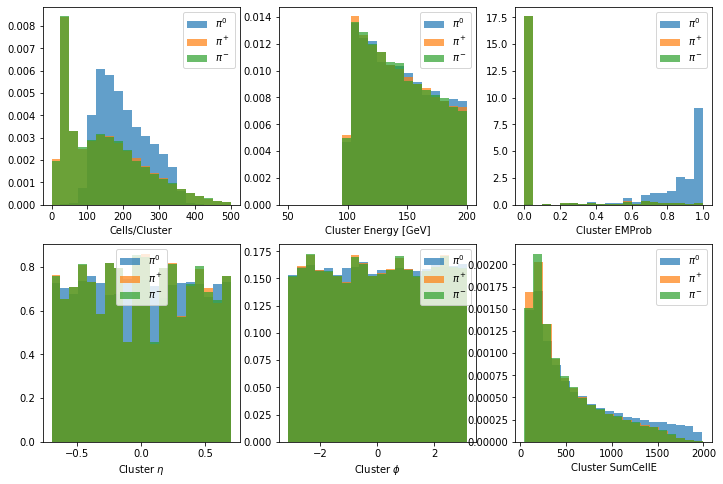

In [13]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=20

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(12,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, density=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, density=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, density=True, range=(0,500), alpha=0.7, label='$\pi^-$')
# ax[0,0].hist(pc['cluster_nCells'], bins=n_bins, density=True, range=(0,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,0].set_xlabel('Cells/Cluster')
# ax[0,0].text(0.6,0.5,'ATLAS Internal',transform=ax[0,0].transAxes)
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, density=True, range=(50,200), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, density=True, range=(50,200), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, density=True, range=(50,200), alpha=0.7, label='$\pi^-$')
# ax[0,1].hist(pc['clusterE'], bins=n_bins, density=True, range=(50,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, density=True, alpha=0.7, label='$\pi^-$')
# ax[1,0].hist(pc['clusterEta'], bins=n_bins, density=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, density=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, density=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

# cluster EM prob
ax[0,2].hist(p0['cluster_EM_PROBABILITY'], bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
ax[0,2].hist(pp['cluster_EM_PROBABILITY'], bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
ax[0,2].hist(pm['cluster_EM_PROBABILITY'], bins=n_bins, density=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, density=True, alpha=0.7, label='$\pi^{\pm}$')
ax[0,2].set_xlabel('Cluster EMProb')
ax[0,2].legend()

# cluster sum cell e
ax[1,2].hist(p0['cluster_sumCellE'], bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
ax[1,2].hist(pp['cluster_sumCellE'], bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
ax[1,2].hist(pm['cluster_sumCellE'], bins=n_bins, density=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, density=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,2].set_xlabel('Cluster SumCellE')
ax[1,2].legend()

plt.savefig(plotpath+'hist_pi0_plus_minus.pdf')
plt.show()


## 1. Simple feed-forward Neural Network

In [5]:
# # Train on E = 0.5-2000 GeV pi0/pi+/pi- samples

# here, define a function to flatten inputs
def format_flat(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

    X = np.append(data_0[layer].reshape((len(data_0[layer]),num_pixels)),
                  data_1[layer].reshape((len(data_1[layer]),num_pixels)), axis=0)

    y = np.append(data_0['label'], data_1['label'], axis=0)

    print (X.shape)
    print (y.shape)
    return X, y, num_pixels

In [6]:
x_flat = {}
y_flat = {}
num_pixels_flat = {}
for layer_i, layer_name in enumerate(layers):
    x_flat[layer_i], y_flat[layer_i], num_pixels_flat[layer_i] = format_flat(p0, pp, layer_i)

(163653, 512)
(163653, 1)
(163653, 256)
(163653, 1)
(163653, 128)
(163653, 1)
(163653, 16)
(163653, 1)
(163653, 16)
(163653, 1)
(163653, 8)
(163653, 1)


In [7]:
#split up data into separate training, validation, and testing

test_size = 24000
validation_size = 24000
from sklearn.model_selection import train_test_split
def make_split_samples(X, y, test_size, validation_size):
    X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
    X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

    # normalize inputs from 0-255 to 0-1
    # this seems to be done already??
#     X_tr = X_tr / 255
#     X_te = X_te / 255
#     X_vl = X_vl / 255

    # one hot encode outputs
    from keras.utils import np_utils
    y_tr_onehot = np_utils.to_categorical(y_tr, 2)
    y_te_onehot = np_utils.to_categorical(y_te, 2)
    y_vl_onehot = np_utils.to_categorical(y_vl, 2)
    num_classes = y_te_onehot.shape[1]
    print("y_train.shape: ",y_tr.shape)
    print("y_train_onehot.shape: ",y_tr_onehot.shape)
    
    return X_tr, X_te, X_vl, y_tr_onehot, y_te_onehot, y_vl_onehot

In [8]:
x_flat_tr = {}
x_flat_te = {}
x_flat_vl = {}
y_flat_tr_onehot = {}
y_flat_te_onehot = {}
y_flat_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_flat_tr[layer_i], x_flat_te[layer_i], x_flat_vl[layer_i], y_flat_tr_onehot[layer_i], y_flat_te_onehot[layer_i], y_flat_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)

Using TensorFlow backend.


y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [10]:
# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        optimizer = Adam(lr=5e-5)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [11]:
# build the model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    models_flat[layer_i] = baseline_nn_model(num_pixels_flat[layer_i])
    models_flat[layer_i].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

In [13]:
# now automated with functions
history_flat = {}
scores = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer %s' % (layer_name))
    history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 200, batch_size = 200*ngpu, verbose = 2)
    scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)
    print('Finished layer %s' % (layer_name))

On layer EMB1
Epoch 1/200
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:

Epoch 75/200
579/579 - 5s - loss: 0.0921 - acc: 0.9706 - val_loss: 0.0892 - val_acc: 0.9720
Epoch 76/200
579/579 - 5s - loss: 0.0922 - acc: 0.9707 - val_loss: 0.0899 - val_acc: 0.9713
Epoch 77/200
579/579 - 5s - loss: 0.0915 - acc: 0.9711 - val_loss: 0.0904 - val_acc: 0.9718
Epoch 78/200
579/579 - 5s - loss: 0.0917 - acc: 0.9710 - val_loss: 0.0902 - val_acc: 0.9715
Epoch 79/200
579/579 - 5s - loss: 0.0916 - acc: 0.9709 - val_loss: 0.0914 - val_acc: 0.9713
Epoch 80/200
579/579 - 5s - loss: 0.0912 - acc: 0.9711 - val_loss: 0.0900 - val_acc: 0.9719
Epoch 81/200
579/579 - 5s - loss: 0.0914 - acc: 0.9710 - val_loss: 0.0895 - val_acc: 0.9716
Epoch 82/200
579/579 - 5s - loss: 0.0906 - acc: 0.9713 - val_loss: 0.0937 - val_acc: 0.9696
Epoch 83/200
579/579 - 5s - loss: 0.0911 - acc: 0.9709 - val_loss: 0.0889 - val_acc: 0.9721
Epoch 84/200
579/579 - 5s - loss: 0.0911 - acc: 0.9712 - val_loss: 0.0905 - val_acc: 0.9712
Epoch 85/200
579/579 - 5s - loss: 0.0906 - acc: 0.9714 - val_loss: 0.0887 - val_

Epoch 164/200
579/579 - 5s - loss: 0.0828 - acc: 0.9742 - val_loss: 0.0843 - val_acc: 0.9745
Epoch 165/200
579/579 - 5s - loss: 0.0815 - acc: 0.9750 - val_loss: 0.0842 - val_acc: 0.9749
Epoch 166/200
579/579 - 5s - loss: 0.0827 - acc: 0.9743 - val_loss: 0.0859 - val_acc: 0.9735
Epoch 167/200
579/579 - 5s - loss: 0.0826 - acc: 0.9742 - val_loss: 0.0848 - val_acc: 0.9743
Epoch 168/200
579/579 - 5s - loss: 0.0822 - acc: 0.9743 - val_loss: 0.0841 - val_acc: 0.9745
Epoch 169/200
579/579 - 5s - loss: 0.0815 - acc: 0.9746 - val_loss: 0.0875 - val_acc: 0.9727
Epoch 170/200
579/579 - 5s - loss: 0.0819 - acc: 0.9745 - val_loss: 0.0849 - val_acc: 0.9740
Epoch 171/200
579/579 - 5s - loss: 0.0815 - acc: 0.9747 - val_loss: 0.0854 - val_acc: 0.9739
Epoch 172/200
579/579 - 5s - loss: 0.0818 - acc: 0.9746 - val_loss: 0.0862 - val_acc: 0.9732
Epoch 173/200
579/579 - 5s - loss: 0.0819 - acc: 0.9746 - val_loss: 0.0856 - val_acc: 0.9735
Epoch 174/200
579/579 - 5s - loss: 0.0820 - acc: 0.9744 - val_loss: 0.

Epoch 53/200
579/579 - 3s - loss: 0.1191 - acc: 0.9645 - val_loss: 0.1114 - val_acc: 0.9669
Epoch 54/200
579/579 - 3s - loss: 0.1181 - acc: 0.9651 - val_loss: 0.1117 - val_acc: 0.9664
Epoch 55/200
579/579 - 3s - loss: 0.1168 - acc: 0.9655 - val_loss: 0.1104 - val_acc: 0.9672
Epoch 56/200
579/579 - 3s - loss: 0.1158 - acc: 0.9658 - val_loss: 0.1086 - val_acc: 0.9675
Epoch 57/200
579/579 - 3s - loss: 0.1141 - acc: 0.9663 - val_loss: 0.1084 - val_acc: 0.9673
Epoch 58/200
579/579 - 3s - loss: 0.1131 - acc: 0.9666 - val_loss: 0.1068 - val_acc: 0.9683
Epoch 59/200
579/579 - 3s - loss: 0.1120 - acc: 0.9670 - val_loss: 0.1065 - val_acc: 0.9692
Epoch 60/200
579/579 - 3s - loss: 0.1106 - acc: 0.9671 - val_loss: 0.1044 - val_acc: 0.9693
Epoch 61/200
579/579 - 3s - loss: 0.1103 - acc: 0.9674 - val_loss: 0.1045 - val_acc: 0.9687
Epoch 62/200
579/579 - 3s - loss: 0.1093 - acc: 0.9675 - val_loss: 0.1039 - val_acc: 0.9688
Epoch 63/200
579/579 - 3s - loss: 0.1080 - acc: 0.9681 - val_loss: 0.1049 - val_

Epoch 142/200
579/579 - 3s - loss: 0.0818 - acc: 0.9763 - val_loss: 0.0816 - val_acc: 0.9772
Epoch 143/200
579/579 - 3s - loss: 0.0819 - acc: 0.9759 - val_loss: 0.0831 - val_acc: 0.9766
Epoch 144/200
579/579 - 3s - loss: 0.0817 - acc: 0.9763 - val_loss: 0.0809 - val_acc: 0.9770
Epoch 145/200
579/579 - 3s - loss: 0.0812 - acc: 0.9764 - val_loss: 0.0834 - val_acc: 0.9766
Epoch 146/200
579/579 - 3s - loss: 0.0814 - acc: 0.9765 - val_loss: 0.0819 - val_acc: 0.9768
Epoch 147/200
579/579 - 3s - loss: 0.0813 - acc: 0.9763 - val_loss: 0.0805 - val_acc: 0.9773
Epoch 148/200
579/579 - 3s - loss: 0.0815 - acc: 0.9762 - val_loss: 0.0812 - val_acc: 0.9768
Epoch 149/200
579/579 - 3s - loss: 0.0811 - acc: 0.9765 - val_loss: 0.0814 - val_acc: 0.9774
Epoch 150/200
579/579 - 3s - loss: 0.0811 - acc: 0.9763 - val_loss: 0.0813 - val_acc: 0.9771
Epoch 151/200
579/579 - 3s - loss: 0.0808 - acc: 0.9763 - val_loss: 0.0817 - val_acc: 0.9772
Epoch 152/200
579/579 - 3s - loss: 0.0805 - acc: 0.9766 - val_loss: 0.

579/579 - 3s - loss: 0.2207 - acc: 0.9184 - val_loss: 0.2202 - val_acc: 0.9168
Epoch 31/200
579/579 - 2s - loss: 0.2187 - acc: 0.9194 - val_loss: 0.2158 - val_acc: 0.9191
Epoch 32/200
579/579 - 3s - loss: 0.2174 - acc: 0.9200 - val_loss: 0.2081 - val_acc: 0.9222
Epoch 33/200
579/579 - 3s - loss: 0.2169 - acc: 0.9204 - val_loss: 0.2064 - val_acc: 0.9233
Epoch 34/200
579/579 - 3s - loss: 0.2152 - acc: 0.9213 - val_loss: 0.2071 - val_acc: 0.9222
Epoch 35/200
579/579 - 3s - loss: 0.2141 - acc: 0.9213 - val_loss: 0.2045 - val_acc: 0.9234
Epoch 36/200
579/579 - 3s - loss: 0.2126 - acc: 0.9222 - val_loss: 0.2115 - val_acc: 0.9213
Epoch 37/200
579/579 - 2s - loss: 0.2119 - acc: 0.9221 - val_loss: 0.2031 - val_acc: 0.9235
Epoch 38/200
579/579 - 3s - loss: 0.2112 - acc: 0.9224 - val_loss: 0.2026 - val_acc: 0.9245
Epoch 39/200
579/579 - 3s - loss: 0.2101 - acc: 0.9233 - val_loss: 0.2011 - val_acc: 0.9244
Epoch 40/200
579/579 - 2s - loss: 0.2087 - acc: 0.9243 - val_loss: 0.2006 - val_acc: 0.9266
E

Epoch 119/200
579/579 - 2s - loss: 0.1569 - acc: 0.9459 - val_loss: 0.1519 - val_acc: 0.9472
Epoch 120/200
579/579 - 2s - loss: 0.1563 - acc: 0.9464 - val_loss: 0.1501 - val_acc: 0.9483
Epoch 121/200
579/579 - 2s - loss: 0.1556 - acc: 0.9469 - val_loss: 0.1475 - val_acc: 0.9497
Epoch 122/200
579/579 - 2s - loss: 0.1559 - acc: 0.9466 - val_loss: 0.1485 - val_acc: 0.9485
Epoch 123/200
579/579 - 3s - loss: 0.1560 - acc: 0.9465 - val_loss: 0.1497 - val_acc: 0.9484
Epoch 124/200
579/579 - 2s - loss: 0.1558 - acc: 0.9468 - val_loss: 0.1465 - val_acc: 0.9500
Epoch 125/200
579/579 - 2s - loss: 0.1567 - acc: 0.9463 - val_loss: 0.1485 - val_acc: 0.9491
Epoch 126/200
579/579 - 2s - loss: 0.1539 - acc: 0.9474 - val_loss: 0.1498 - val_acc: 0.9492
Epoch 127/200
579/579 - 3s - loss: 0.1541 - acc: 0.9475 - val_loss: 0.1502 - val_acc: 0.9478
Epoch 128/200
579/579 - 2s - loss: 0.1548 - acc: 0.9471 - val_loss: 0.1562 - val_acc: 0.9476
Epoch 129/200
579/579 - 2s - loss: 0.1549 - acc: 0.9468 - val_loss: 0.

Epoch 7/200
579/579 - 1s - loss: 0.3973 - acc: 0.8927 - val_loss: 0.3662 - val_acc: 0.8991
Epoch 8/200
579/579 - 1s - loss: 0.3716 - acc: 0.8950 - val_loss: 0.3440 - val_acc: 0.8993
Epoch 9/200
579/579 - 1s - loss: 0.3524 - acc: 0.8956 - val_loss: 0.3269 - val_acc: 0.8999
Epoch 10/200
579/579 - 1s - loss: 0.3370 - acc: 0.8970 - val_loss: 0.3136 - val_acc: 0.9004
Epoch 11/200
579/579 - 1s - loss: 0.3262 - acc: 0.8975 - val_loss: 0.3036 - val_acc: 0.9005
Epoch 12/200
579/579 - 1s - loss: 0.3177 - acc: 0.8977 - val_loss: 0.2955 - val_acc: 0.9012
Epoch 13/200
579/579 - 1s - loss: 0.3115 - acc: 0.8983 - val_loss: 0.2899 - val_acc: 0.9018
Epoch 14/200
579/579 - 1s - loss: 0.3073 - acc: 0.8993 - val_loss: 0.2856 - val_acc: 0.9028
Epoch 15/200
579/579 - 1s - loss: 0.3034 - acc: 0.8997 - val_loss: 0.2825 - val_acc: 0.9028
Epoch 16/200
579/579 - 1s - loss: 0.3002 - acc: 0.9003 - val_loss: 0.2803 - val_acc: 0.9031
Epoch 17/200
579/579 - 1s - loss: 0.2995 - acc: 0.9006 - val_loss: 0.2784 - val_acc

579/579 - 1s - loss: 0.2725 - acc: 0.9100 - val_loss: 0.2587 - val_acc: 0.9124
Epoch 97/200
579/579 - 1s - loss: 0.2727 - acc: 0.9101 - val_loss: 0.2587 - val_acc: 0.9125
Epoch 98/200
579/579 - 1s - loss: 0.2730 - acc: 0.9099 - val_loss: 0.2586 - val_acc: 0.9125
Epoch 99/200
579/579 - 1s - loss: 0.2726 - acc: 0.9100 - val_loss: 0.2586 - val_acc: 0.9124
Epoch 100/200
579/579 - 1s - loss: 0.2734 - acc: 0.9096 - val_loss: 0.2585 - val_acc: 0.9125
Epoch 101/200
579/579 - 1s - loss: 0.2721 - acc: 0.9102 - val_loss: 0.2584 - val_acc: 0.9125
Epoch 102/200
579/579 - 1s - loss: 0.2724 - acc: 0.9104 - val_loss: 0.2583 - val_acc: 0.9124
Epoch 103/200
579/579 - 1s - loss: 0.2715 - acc: 0.9102 - val_loss: 0.2582 - val_acc: 0.9125
Epoch 104/200
579/579 - 1s - loss: 0.2729 - acc: 0.9100 - val_loss: 0.2582 - val_acc: 0.9125
Epoch 105/200
579/579 - 1s - loss: 0.2730 - acc: 0.9105 - val_loss: 0.2583 - val_acc: 0.9125
Epoch 106/200
579/579 - 1s - loss: 0.2714 - acc: 0.9103 - val_loss: 0.2580 - val_acc: 0

Epoch 185/200
579/579 - 1s - loss: 0.2673 - acc: 0.9114 - val_loss: 0.2553 - val_acc: 0.9135
Epoch 186/200
579/579 - 1s - loss: 0.2685 - acc: 0.9110 - val_loss: 0.2558 - val_acc: 0.9132
Epoch 187/200
579/579 - 1s - loss: 0.2684 - acc: 0.9111 - val_loss: 0.2551 - val_acc: 0.9134
Epoch 188/200
579/579 - 1s - loss: 0.2674 - acc: 0.9111 - val_loss: 0.2551 - val_acc: 0.9134
Epoch 189/200
579/579 - 1s - loss: 0.2691 - acc: 0.9111 - val_loss: 0.2552 - val_acc: 0.9135
Epoch 190/200
579/579 - 1s - loss: 0.2684 - acc: 0.9111 - val_loss: 0.2554 - val_acc: 0.9133
Epoch 191/200
579/579 - 1s - loss: 0.2680 - acc: 0.9109 - val_loss: 0.2551 - val_acc: 0.9133
Epoch 192/200
579/579 - 1s - loss: 0.2687 - acc: 0.9112 - val_loss: 0.2548 - val_acc: 0.9137
Epoch 193/200
579/579 - 1s - loss: 0.2682 - acc: 0.9109 - val_loss: 0.2549 - val_acc: 0.9135
Epoch 194/200
579/579 - 1s - loss: 0.2680 - acc: 0.9109 - val_loss: 0.2549 - val_acc: 0.9135
Epoch 195/200
579/579 - 1s - loss: 0.2685 - acc: 0.9111 - val_loss: 0.

Epoch 74/200
579/579 - 1s - loss: 0.2513 - acc: 0.9179 - val_loss: 0.2378 - val_acc: 0.9215
Epoch 75/200
579/579 - 1s - loss: 0.2512 - acc: 0.9182 - val_loss: 0.2376 - val_acc: 0.9222
Epoch 76/200
579/579 - 1s - loss: 0.2510 - acc: 0.9180 - val_loss: 0.2377 - val_acc: 0.9216
Epoch 77/200
579/579 - 1s - loss: 0.2508 - acc: 0.9182 - val_loss: 0.2373 - val_acc: 0.9220
Epoch 78/200
579/579 - 1s - loss: 0.2513 - acc: 0.9182 - val_loss: 0.2372 - val_acc: 0.9222
Epoch 79/200
579/579 - 1s - loss: 0.2507 - acc: 0.9185 - val_loss: 0.2371 - val_acc: 0.9223
Epoch 80/200
579/579 - 1s - loss: 0.2508 - acc: 0.9185 - val_loss: 0.2369 - val_acc: 0.9222
Epoch 81/200
579/579 - 1s - loss: 0.2493 - acc: 0.9184 - val_loss: 0.2370 - val_acc: 0.9221
Epoch 82/200
579/579 - 1s - loss: 0.2504 - acc: 0.9184 - val_loss: 0.2367 - val_acc: 0.9223
Epoch 83/200
579/579 - 1s - loss: 0.2501 - acc: 0.9184 - val_loss: 0.2367 - val_acc: 0.9222
Epoch 84/200
579/579 - 1s - loss: 0.2491 - acc: 0.9186 - val_loss: 0.2370 - val_

Epoch 163/200
579/579 - 1s - loss: 0.2431 - acc: 0.9209 - val_loss: 0.2310 - val_acc: 0.9246
Epoch 164/200
579/579 - 1s - loss: 0.2425 - acc: 0.9209 - val_loss: 0.2309 - val_acc: 0.9248
Epoch 165/200
579/579 - 1s - loss: 0.2424 - acc: 0.9208 - val_loss: 0.2308 - val_acc: 0.9247
Epoch 166/200
579/579 - 1s - loss: 0.2426 - acc: 0.9210 - val_loss: 0.2310 - val_acc: 0.9246
Epoch 167/200
579/579 - 1s - loss: 0.2436 - acc: 0.9209 - val_loss: 0.2307 - val_acc: 0.9249
Epoch 168/200
579/579 - 1s - loss: 0.2434 - acc: 0.9209 - val_loss: 0.2307 - val_acc: 0.9248
Epoch 169/200
579/579 - 1s - loss: 0.2428 - acc: 0.9208 - val_loss: 0.2309 - val_acc: 0.9247
Epoch 170/200
579/579 - 1s - loss: 0.2428 - acc: 0.9209 - val_loss: 0.2310 - val_acc: 0.9245
Epoch 171/200
579/579 - 1s - loss: 0.2432 - acc: 0.9208 - val_loss: 0.2308 - val_acc: 0.9249
Epoch 172/200
579/579 - 1s - loss: 0.2433 - acc: 0.9210 - val_loss: 0.2306 - val_acc: 0.9249
Epoch 173/200
579/579 - 1s - loss: 0.2425 - acc: 0.9210 - val_loss: 0.

Epoch 52/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 53/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 54/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 55/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 56/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 57/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 58/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 59/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 60/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 61/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 62/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_

Epoch 141/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 142/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 143/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 144/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 145/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 146/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 147/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 148/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 149/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 150/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 151/200
579/579 - 1s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.

In [14]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    models_flat[layer_i].save(modelpath+'model_{}_flat_do20.h5'.format(layer_name))

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


In [23]:
#alternate to fitting the model: load a saved model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    print('Loading {}'.format(layer_name))
    models_flat[layer_i] = tf.keras.models.load_model(modelpath+'model_{}_flat_do20.h5'.format(layer_name))

Loading EMB1
Loading EMB2
Loading EMB3
Loading TileBar0
Loading TileBar1
Loading TileBar2


<Figure size 432x288 with 0 Axes>

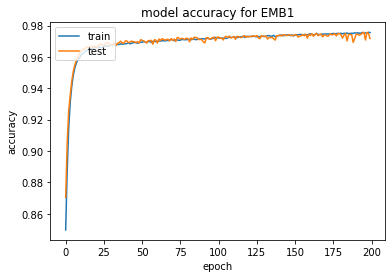

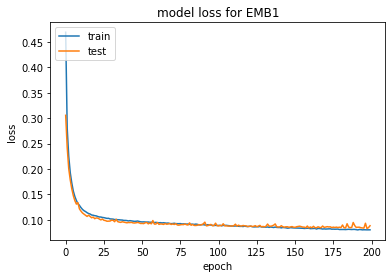

<Figure size 432x288 with 0 Axes>

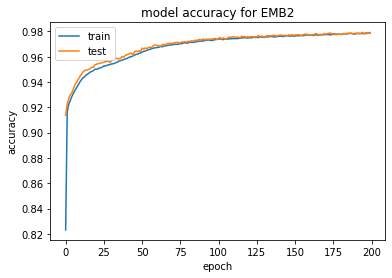

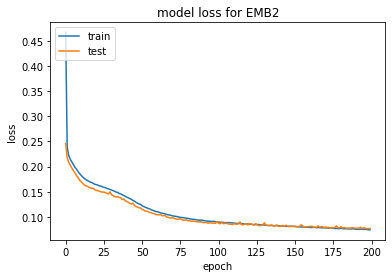

<Figure size 432x288 with 0 Axes>

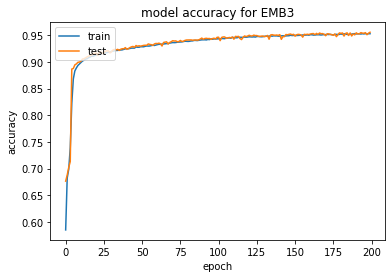

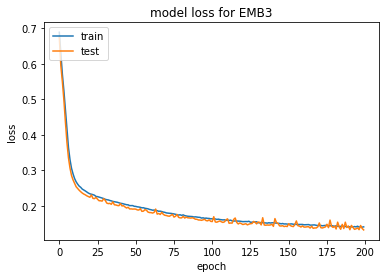

<Figure size 432x288 with 0 Axes>

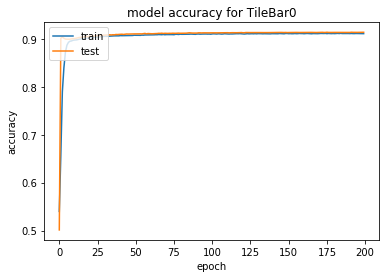

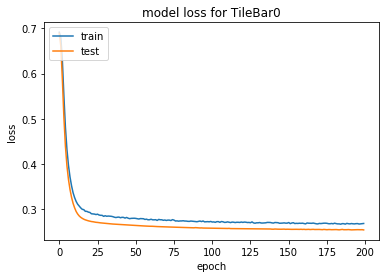

<Figure size 432x288 with 0 Axes>

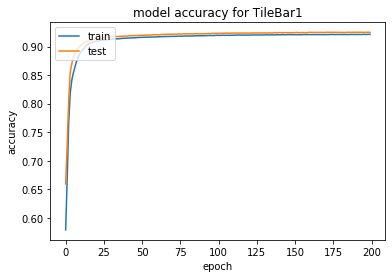

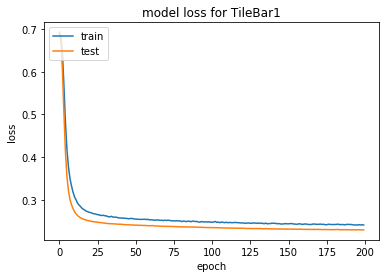

<Figure size 432x288 with 0 Axes>

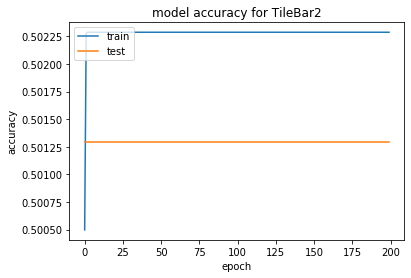

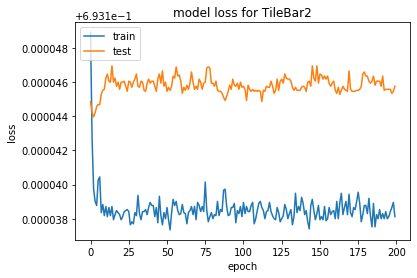

In [15]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_flat[layer_i].history['acc'])
    plt.plot(history_flat[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('plots/accuracy_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_flat[layer_i].history['loss'])
    plt.plot(history_flat[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('plots/loss_{}.pdf'.format(layer_name))
    plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc

In [17]:
# roc curves, for all layers


y_flat_pred = {}
fpr_flat_nn = {} 
tpr_flat_nn = {} 
thres_flat_nn = {}
auc_flat_nn = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
    fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1],drop_intermediate=False)
    auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
    print("Area under curve: {}".format(auc_flat_nn[layer_i]))

Area under curve: 0.9913556684390019
Area under curve: 0.9926146627535516
Area under curve: 0.9855611452833674
Area under curve: 0.932244206549762
Area under curve: 0.9326660750271862
Area under curve: 0.5


In [18]:
x_lc = np.append(1-p0['cluster_EM_PROBABILITY'],1 - pp['cluster_EM_PROBABILITY'])
y_lc = np.append(p0['label'], pp['label']) 

In [19]:
fpr_lc, tpr_lc, thresh_lc = roc_curve(y_lc, x_lc)
auc_lc = auc(fpr_lc, tpr_lc)
print("Area under curve: {}".format(auc_lc))

Area under curve: 0.9787681202060897


<Figure size 432x288 with 0 Axes>

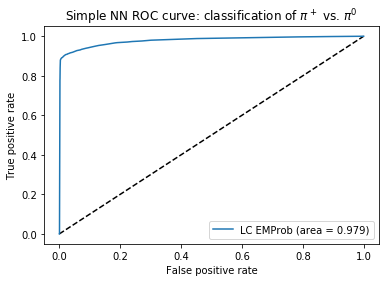

In [20]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('plots/roc_lc_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

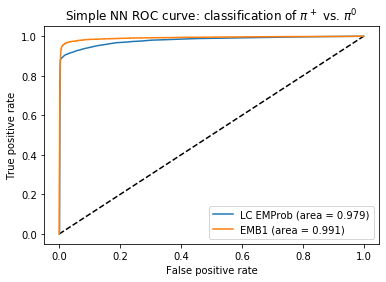

In [21]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_flat_nn[0], tpr_flat_nn[0], label='{} (area = {:.3f})'.format('EMB1', auc_flat_nn[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('plots/roc_lc_emb1_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

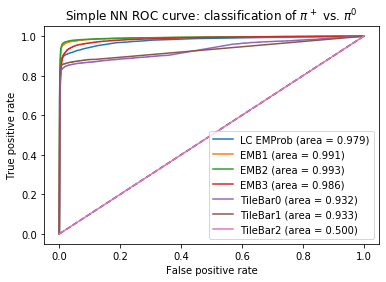

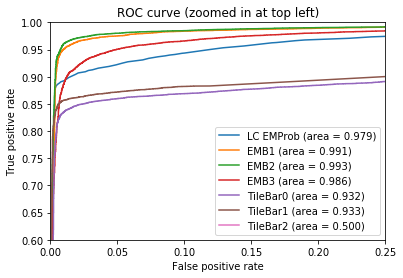

In [22]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('plots/roc_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('plots/roc_zoom_layers.pdf')
plt.show()


In [23]:
y_flat_pred_stack = np.column_stack((y_flat_pred[0][:,1], y_flat_pred[1][:,1],y_flat_pred[2][:,1],y_flat_pred[3][:,1],y_flat_pred[4][:,1],y_flat_pred[5][:,1]))

y_flat_pred_vl = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred_vl[layer_i] = models_flat[layer_i].predict(x_flat_vl[layer_i])
#     print len(y_flat_pred_vl[layer_i])

y_flat_pred_vl_stack = np.column_stack((y_flat_pred_vl[0][:,1], y_flat_pred_vl[1][:,1],y_flat_pred_vl[2][:,1],y_flat_pred_vl[3][:,1],y_flat_pred_vl[4][:,1],y_flat_pred_vl[5][:,1]))

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
history_simpleCombine = model_simpleCombine.fit(y_flat_pred_stack, y_flat_te_onehot[0], epochs = 200, batch_size = 200*ngpu, verbose = 2)

Epoch 1/200
120/120 - 0s - loss: 0.6814 - acc: 0.7893
Epoch 2/200
120/120 - 0s - loss: 0.5005 - acc: 0.9573
Epoch 3/200
120/120 - 0s - loss: 0.2989 - acc: 0.9735
Epoch 4/200
120/120 - 0s - loss: 0.2204 - acc: 0.9820
Epoch 5/200
120/120 - 0s - loss: 0.1256 - acc: 0.9858
Epoch 6/200
120/120 - 0s - loss: 0.0677 - acc: 0.9870
Epoch 7/200
120/120 - 0s - loss: 0.0564 - acc: 0.9870
Epoch 8/200
120/120 - 0s - loss: 0.0538 - acc: 0.9869
Epoch 9/200
120/120 - 0s - loss: 0.0530 - acc: 0.9870
Epoch 10/200
120/120 - 0s - loss: 0.0526 - acc: 0.9871
Epoch 11/200
120/120 - 0s - loss: 0.0524 - acc: 0.9868
Epoch 12/200
120/120 - 0s - loss: 0.0523 - acc: 0.9870
Epoch 13/200
120/120 - 0s - loss: 0.0522 - acc: 0.9869
Epoch 14/200
120/120 - 0s - loss: 0.0522 - acc: 0.9870
Epoch 15/200
120/120 - 0s - loss: 0.0521 - acc: 0.9869
Epoch 16/200
120/120 - 0s - loss: 0.0521 - acc: 0.9871
Epoch 17/200
120/120 - 0s - loss: 0.0520 - acc: 0.9869
Epoch 18/200
120/120 - 0s - loss: 0.0520 - acc: 0.9869
Epoch 19/200
120/12

120/120 - 0s - loss: 0.0512 - acc: 0.9870
Epoch 150/200
120/120 - 0s - loss: 0.0512 - acc: 0.9870
Epoch 151/200
120/120 - 0s - loss: 0.0511 - acc: 0.9868
Epoch 152/200
120/120 - 0s - loss: 0.0511 - acc: 0.9870
Epoch 153/200
120/120 - 0s - loss: 0.0511 - acc: 0.9870
Epoch 154/200
120/120 - 0s - loss: 0.0511 - acc: 0.9871
Epoch 155/200
120/120 - 0s - loss: 0.0511 - acc: 0.9872
Epoch 156/200
120/120 - 0s - loss: 0.0511 - acc: 0.9867
Epoch 157/200
120/120 - 0s - loss: 0.0512 - acc: 0.9870
Epoch 158/200
120/120 - 0s - loss: 0.0511 - acc: 0.9870
Epoch 159/200
120/120 - 0s - loss: 0.0511 - acc: 0.9869
Epoch 160/200
120/120 - 0s - loss: 0.0511 - acc: 0.9869
Epoch 161/200
120/120 - 0s - loss: 0.0511 - acc: 0.9868
Epoch 162/200
120/120 - 0s - loss: 0.0511 - acc: 0.9870
Epoch 163/200
120/120 - 0s - loss: 0.0511 - acc: 0.9870
Epoch 164/200
120/120 - 0s - loss: 0.0511 - acc: 0.9872
Epoch 165/200
120/120 - 0s - loss: 0.0511 - acc: 0.9870
Epoch 166/200
120/120 - 0s - loss: 0.0512 - acc: 0.9870
Epoch 

<Figure size 432x288 with 0 Axes>

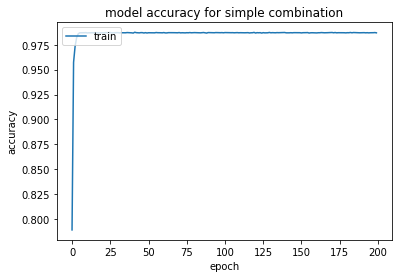

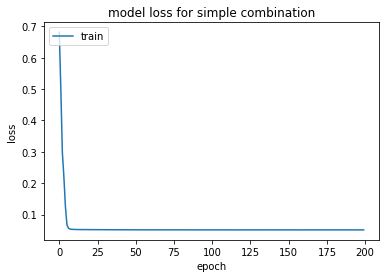

In [25]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_simpleCombine.history['acc'])
#     plt.plot(history_simpleCombine.history['val_acc'])
    plt.title('model accuracy for simple combination')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'accuracy_simpleCombine.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_simpleCombine.history['loss'])
#     plt.plot(history_simpleCombine.history['val_loss'])
    plt.title('model loss for simple combination')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'loss_simpleCombine.pdf')
    plt.show()
    

In [26]:
combined_pred = model_simpleCombine.predict(y_flat_pred_vl_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print(auc_combined)

0.9970681644618475


<Figure size 432x288 with 0 Axes>

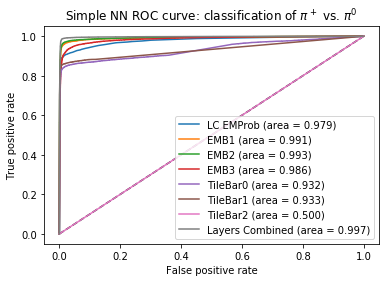

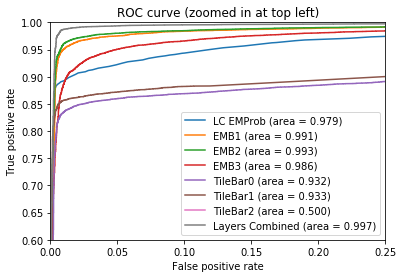

In [27]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_combine1_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_zoom_combine1_layers.pdf')
plt.show()


In [124]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [125]:
with strategy.scope():    

    model_combine = Sequential()

    #EMB1
    input1 = Input(shape=(512,), name = 'input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)

    #EMB2
    input2 = Input(shape=(256,), name = 'input2')
    x2 = Dense(256, activation='relu')(input2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(64, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)

    #EMB3
    input3 = Input(shape=(128,), name = 'input3')
    x3 = Dense(128, activation='relu')(input3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(64, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(32, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)

    #Tile0
    input4 = Input(shape=(16,), name = 'input4')
    x4 = Dense(16, activation='relu')(input4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(8, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(4, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)

    #Tile1
    input5 = Input(shape=(16,), name = 'input5')
    x5 = Dense(16, activation='relu')(input5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(8, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(4, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)

    #Tile2
    input6 = Input(shape=(8,), name = 'input6')
    x6 = Dense(8, activation='relu')(input6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(4, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(2, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)

    #Combination
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)

    output_combine = Dense(2, activation='softmax')(x)

    model_combine = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output_combine])
    model_combine.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['acc'])   

INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).


In [ ]:
# history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], [y_flat_tr_onehot[0]], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], [y_flat_vl_onehot[0]]), epochs=200, batch_size=200*ngpu, verbose=2)

# it works when I take the Y data out of a list, otherwise AttributeError
history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], y_flat_tr_onehot[0], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], y_flat_vl_onehot[0]), epochs=200, batch_size=200*ngpu, verbose=2)

Instructions for updating:
Use the iterator's `initializer` property instead.
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).


/home/mfong/.local/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:492: UserWarning: `tf.keras.backend.learning_phase_scope` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.learning_phase_scope` is deprecated and '


INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
Train on 579 steps, validate on 120 steps
Epoch 1/200


/home/mfong/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


579/579 - 8s - loss: 0.3449 - acc: 0.8903 - val_loss: 0.1135 - val_acc: 0.9597
Epoch 2/200
579/579 - 7s - loss: 0.1209 - acc: 0.9613 - val_loss: 0.0836 - val_acc: 0.9736
Epoch 3/200
579/579 - 7s - loss: 0.1001 - acc: 0.9701 - val_loss: 0.0775 - val_acc: 0.9765
Epoch 4/200
579/579 - 7s - loss: 0.0917 - acc: 0.9729 - val_loss: 0.0708 - val_acc: 0.9801
Epoch 5/200
579/579 - 7s - loss: 0.0851 - acc: 0.9759 - val_loss: 0.0678 - val_acc: 0.9808
Epoch 6/200
579/579 - 7s - loss: 0.0812 - acc: 0.9775 - val_loss: 0.0655 - val_acc: 0.9823
Epoch 7/200
579/579 - 7s - loss: 0.0788 - acc: 0.9779 - val_loss: 0.0643 - val_acc: 0.9826
Epoch 8/200
579/579 - 7s - loss: 0.0760 - acc: 0.9792 - val_loss: 0.0628 - val_acc: 0.9833
Epoch 9/200
579/579 - 7s - loss: 0.0748 - acc: 0.9797 - val_loss: 0.0629 - val_acc: 0.9831
Epoch 10/200
579/579 - 7s - loss: 0.0734 - acc: 0.9798 - val_loss: 0.0613 - val_acc: 0.9838
Epoch 11/200
579/579 - 7s - loss: 0.0711 - acc: 0.9808 - val_loss: 0.0615 - val_acc: 0.9833
Epoch 12/

Epoch 91/200
579/579 - 7s - loss: 0.0466 - acc: 0.9883 - val_loss: 0.0434 - val_acc: 0.9885
Epoch 92/200
579/579 - 7s - loss: 0.0461 - acc: 0.9886 - val_loss: 0.0438 - val_acc: 0.9887
Epoch 93/200
579/579 - 7s - loss: 0.0462 - acc: 0.9887 - val_loss: 0.0457 - val_acc: 0.9886
Epoch 94/200
579/579 - 7s - loss: 0.0462 - acc: 0.9884 - val_loss: 0.0437 - val_acc: 0.9888
Epoch 95/200
579/579 - 7s - loss: 0.0459 - acc: 0.9886 - val_loss: 0.0429 - val_acc: 0.9890
Epoch 96/200
579/579 - 7s - loss: 0.0460 - acc: 0.9885 - val_loss: 0.0443 - val_acc: 0.9890
Epoch 97/200
579/579 - 7s - loss: 0.0457 - acc: 0.9886 - val_loss: 0.0442 - val_acc: 0.9890
Epoch 98/200
579/579 - 7s - loss: 0.0460 - acc: 0.9886 - val_loss: 0.0425 - val_acc: 0.9890
Epoch 99/200
579/579 - 7s - loss: 0.0449 - acc: 0.9890 - val_loss: 0.0438 - val_acc: 0.9889
Epoch 100/200
579/579 - 7s - loss: 0.0454 - acc: 0.9887 - val_loss: 0.0437 - val_acc: 0.9888
Epoch 101/200


In [ ]:
model_combine.save(modelpath+"model_deep_do20.h5")

In [78]:
model_combine = tf.keras.models.load_model(modelpath+"model_deep_do20.h5")

<Figure size 432x288 with 0 Axes>

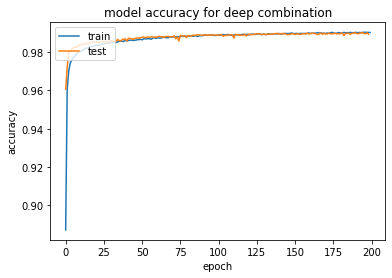

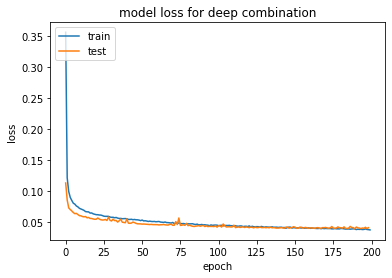

In [49]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_combine.history['acc'])
plt.plot(history_combine.history['val_acc'])
plt.title('model accuracy for deep combination')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/accuracy_deepCombine.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_combine.history['loss'])
plt.plot(history_combine.history['val_loss'])
plt.title('model loss for deep combination')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/loss_deepCombine.pdf')
plt.show()


In [50]:
y_combine_pred = model_combine.predict([x_flat_te[0], x_flat_te[1], x_flat_te[2], x_flat_te[3], x_flat_te[4], x_flat_te[5]])
fpr_combine, tpr_combine, thres_combine = roc_curve(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])
auc_combine = auc(fpr_combine, tpr_combine)
print("Area under curve: {}".format(auc_combine))

Area under curve: 0.39797833200610977


<Figure size 432x288 with 0 Axes>

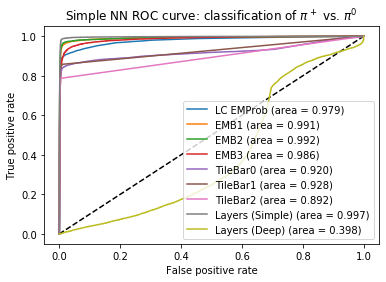

<Figure size 432x288 with 0 Axes>

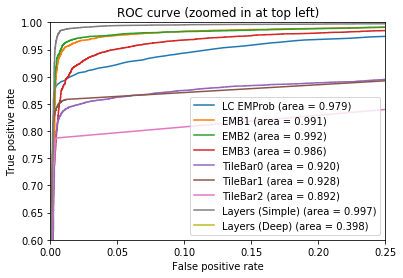

In [59]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('plots/roc_combine2_layers.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('plots/roc_zoom_combine2_layers.pdf')
plt.show()


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

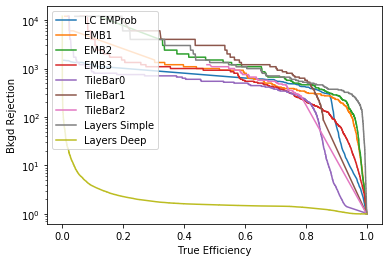

In [60]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.yscale('log')
plt.plot(tpr_lc, 1/fpr_lc, label='LC EMProb')
for layer_i, layer_name in enumerate(layers):
    plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
plt.plot(tpr_simpleCombine, 1/fpr_simpleCombine, label='Layers Simple')
plt.plot(tpr_combine, 1/fpr_combine, label='Layers Deep')
plt.legend(loc='best')
plt.xlabel('True Efficiency')
plt.ylabel('Bkgd Rejection')
plt.savefig(plotpath+'roc_reg_combine2_layers.pdf')
plt.show()


In [84]:
#function to split apart a prediction list according to the one hot values.
#really, could have done this by evaluating the nn with a non-concatted nparray, but we already have this handy
def split_pred(onehot, pred):
    list_one = [element_n for element_n, element in enumerate(onehot) if element==1]
    one_vals = [element for element_n, element in enumerate(pred) if element_n in list_one]
    zer_vals = [element for element_n, element in enumerate(pred) if element_n not in list_one]
    
    return one_vals, zer_vals

<Figure size 432x288 with 0 Axes>

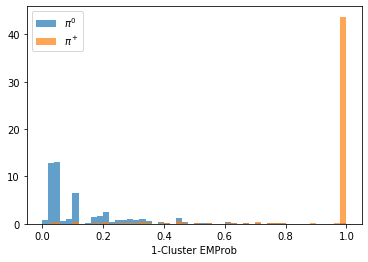

<Figure size 432x288 with 0 Axes>

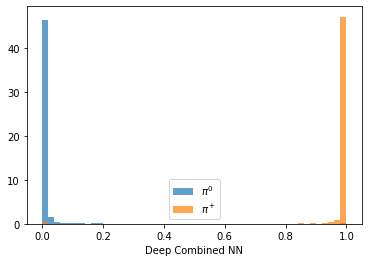

<Figure size 432x288 with 0 Axes>

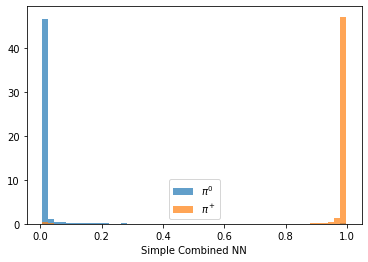

<Figure size 432x288 with 0 Axes>

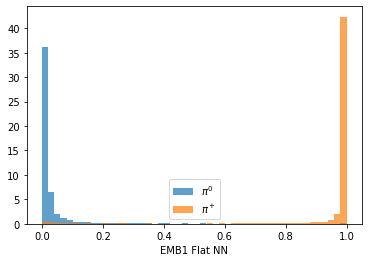

<Figure size 432x288 with 0 Axes>

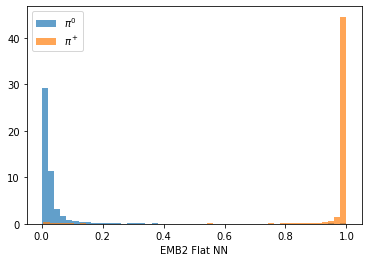

<Figure size 432x288 with 0 Axes>

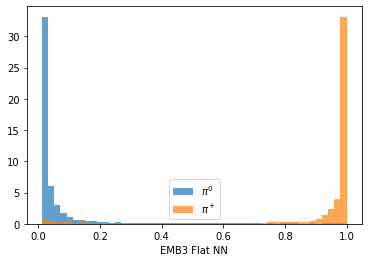

<Figure size 432x288 with 0 Axes>

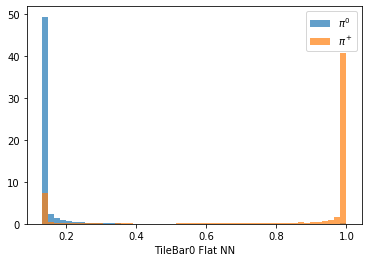

<Figure size 432x288 with 0 Axes>

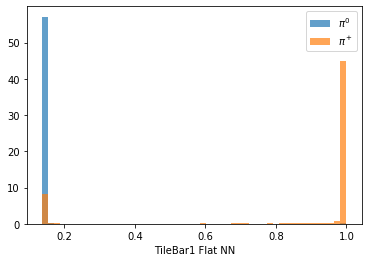

<Figure size 432x288 with 0 Axes>

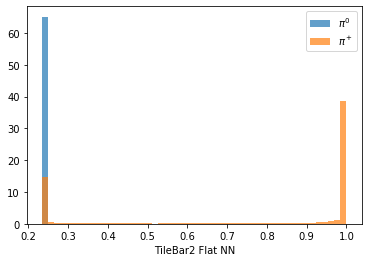

In [85]:
n_bins = 50
#time for histogramming
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(1-p0['cluster_EM_PROBABILITY'], bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
plt.hist(1-pp['cluster_EM_PROBABILITY'], bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('1-Cluster EMProb')
plt.legend()
plt.savefig('plots/hist_emprob.pdf')
plt.show()

pip_vals_combine, p0_vals_combine = split_pred(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_combine, bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_combine, bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Deep Combined NN')
plt.legend()
plt.savefig('plots/hist_deep.pdf')
plt.show()

pip_vals_simpleCombine, p0_vals_simpleCombine = split_pred(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_simpleCombine, bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_simpleCombine, bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Simple Combined NN')
plt.legend()
plt.savefig('plots/hist_simple.pdf')
plt.show()

pip_vals_flat = {}
p0_vals_flat = {}
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    pip_vals_flat[layer_i], p0_vals_flat[layer_i] = split_pred(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(p0_vals_flat[layer_i], bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
    plt.hist(pip_vals_flat[layer_i], bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
    plt.xlabel('{} Flat NN'.format(layer_name))
    plt.legend()
    plt.savefig('plots/hist_flatnn_{}.pdf'.format(layer_name))
    plt.show()

## 2. Convolutional Neural Network

In [31]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
    X = np.append(data_0[layer], data_1[layer], axis=0)
    X = X.reshape(X.shape[0], 1, len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)
    return X, Y, num_pixels

In [32]:
#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(158653, 1, 16, 16)
(158653, 1)
y_train.shape:  (158653, 1)
y_train_onehot.shape:  (158653, 2)


In [33]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import backend as K
# K.image_data_format('th')
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)

In [34]:
# split up into training and test datasets, using functions
test_size = 24000
validation_size = 24000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_cnn[layer_i], y_cnn[layer_i], test_size, validation_size)


y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)


In [35]:
# define a simple convolutional model
def baseline_ccn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [67]:
# define a simple convolutional model

filters = [(2,4), (4,4), (4,4), (2,2), (2,2), (2,1)]

def baseline_cnn_model_layers(layer_i):
    # create model
    with strategy.scope():
        model = Sequential()
        model.add(Conv2D(32, filters[layer_i], input_shape=(1,len_phi[layer_i],len_eta[layer_i]), activation='relu', data_format="channels_first"))
#         model.add(Conv2D(32, filters[layer_i], input_shape=(len_phi[layer_i],len_eta[layer_i],1), activation='relu', data_format="channels_last"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [68]:
model_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print(layer_name)
    print(len_phi[layer_i])
    print(len_eta[layer_i])
    model_cnn_base_layers[layer_i] = baseline_cnn_model_layers(layer_i)
    model_cnn_base_layers[layer_i].summary()

EMB1
4
128
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 3, 125)        288       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 1, 62)         0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 32, 1, 62)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1984)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 128)               254080    
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 258       
Total params: 254,626
Trainable params: 254,626
Non-trainable params: 0
____________________________________

In [69]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [70]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 6, 6)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 5, 5)          2064      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 2, 2)          0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 16, 2, 2)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 128)             

In [71]:
test_x_tr = {}
test_x_vl = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer {}'.format(layer_name))
    test_x_tr[layer_i] = np.transpose(x_cnn_tr[layer_i], (0,2,3,1))
    test_x_vl[layer_i] = np.transpose(x_cnn_vl[layer_i], (0,2,3,1))

On layer EMB1
On layer EMB2
On layer EMB3
On layer TileBar0
On layer TileBar1
On layer TileBar2


In [72]:
test_x_tr[layer_i].shape

(115653, 4, 2, 1)

In [73]:
x_cnn_tr[0].shape

(115653, 1, 4, 128)

In [74]:
x_cnn_vl[0].shape

(24000, 1, 4, 128)

In [75]:
import tensorflow as tf

In [76]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3897999084494448279]

In [77]:
history_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer {}'.format(layer_name))
    history_cnn_base_layers[layer_i] = model_cnn_base_layers[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=200, batch_size=200*ngpu, verbose=2)
    # testing transpose    
#     history_cnn_base_layers[layer_i] = model_cnn_base_layers[layer_i].fit(test_x_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(test_x_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=200, batch_size=200*ngpu, verbose=2)


On layer EMB1
Epoch 1/200


InvalidArgumentError:  Default MaxPoolingOp only supports NHWC on device type CPU
	 [[node sequential_29/max_pooling2d_24/MaxPool (defined at opt/anaconda3/envs/shared_env/lib/python3.6/threading.py:916) ]] [Op:__inference_train_function_1886046]

Function call stack:
train_function


In [ ]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_base_layers[layer_i].history['acc'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_cnn_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_base_layers[layer_i].history['loss'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_cnn_{}.pdf'.format(layer_name))
    plt.show()

In [ ]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=40, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_baseline_pred = model_cnn_base.predict(X_te)
fpr_baseline, tpr_baseline, thres_baseline = roc_curve(y_te_onehot[:,1], y_baseline_pred[:,1])
auc_baseline = auc(fpr_baseline, tpr_baseline)
print("Area under curve: {}".format(auc_baseline))

y_large_pred = model_cnn_large.predict(X_te)
fpr_large, tpr_large, thres_large = roc_curve(y_te_onehot[:,1], y_large_pred[:,1])
auc_large = auc(fpr_large, tpr_large)
print("Area under curve: {}".format(auc_large))

In [ ]:
y_baseline_layers_pred = {}
fpr_baseline_layers = {}
tpr_baseline_layers = {}
thres_baseline_layers = {}
auc_baseline_layers = {}
for layer_i, layer_name in enumerate(layers):
    y_baseline_layers_pred[layer_i] = model_cnn_base_layers[layer_i].predict(x_cnn_te[layer_i])
    fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], thres_baseline_layers[layer_i] = roc_curve(y_cnn_te_onehot[layer_i][:,1], y_baseline_layers_pred[layer_i][:,1])
    auc_baseline_layers[layer_i] = auc(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i])
    print("Area under curve: {}".format(auc_baseline_layers[layer_i]))
#     y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
#     fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
#     auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
#     print("Area under curve: {}".format(auc_flat_nn[layer_i]))


In [ ]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    model_cnn_base_layers[layer_i].save(modelpath+"model_{}_cnn_base.h5".format(layer_name))

In [ ]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_cnn.pdf')
plt.show()

In [ ]:
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()


    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    # Zoom in view of the upper left corner.
    plt.xlim(0, 0.25)
    plt.ylim(0.6, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    # ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_zoom_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [78]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print(X0.shape)
print(X1.shape)
print(X2.shape)
print(y.shape)

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print(X0_tr.shape)
print(y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(163653, 512)
(163653, 1, 16, 16)
(163653, 1, 8, 16)
(163653, 1)
(153653, 512)
(153653, 1)
y_train.shape:  (153653, 1)
y_train_onehot.shape:  (153653, 2)


In [95]:
# define convolutional model for multiple input images

# from keras.models import Model
# from keras.layers import concatenate
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.utils import np_utils
# from keras import backend as K

# K.set_image_dim_ordering('th')

In [116]:
"""
repeat of above but supports tf2
"""

# define convolutional model for multiple input images

from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.python.keras import backend as K
# from tensorflow.keras import backend as k

# K.set_image_dim_ordering('th')

In [117]:
# create model

def merged_model_emb12():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [115]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
"""
code from above merged_model_emb12() taken out of function
"""
#EMB1
input1 = Input(shape=(512,), name = 'input1')
x1 = Dense(512, activation='relu')(input1)
x1 = Dropout(0.2)(x1)
x1 = Dense(256, activation='relu')(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.2)(x1)

# model1 = Sequential()
# model1.add(Input(shape=(512,), name='input1'))
# model1.add(Dense(512, activation='relu'))
# model1.add(Dense(256, activation='relu')) 
# model1.add(Dense(128, activation='relu'))

# EMB2 image (convolutional)
input2 = Input(shape=(1,16,16), name='input2')
x2 = Conv2D(32, (4, 4), activation='relu')(input2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Dropout(0.2)(x2)
x2 = Flatten()(x2)
x2 = Dense(128, activation='relu')(x2)

# concatenate outputs from the two networks above
x = concatenate([x1, x2]) 
x = Dense(50, activation='relu')(x)    

# final output
output = Dense(2, activation='softmax')(x)

model = Model(inputs = [input1, input2], outputs = [output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

In [118]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 1, 16, 16)]  0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 32, 13, 13)   544         input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 32, 6, 6)     0           conv2d_41[0][0]                  
____________________________________________________________________________________________

In [119]:
# fit (train) the merged model
history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 153653 samples, validate on 2000 samples
Epoch 1/80


InvalidArgumentError: Default MaxPoolingOp only supports NHWC on device type CPU
	 [[{{node max_pooling2d_39/MaxPool}}]]

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [120]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [121]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 1, 16, 16)]  0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             [(None, 1, 8, 16)]   0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 13, 13)   544         input2[0][0]                     
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 7, 13)    288         input3[0][0]                     
____________________________________________________________________________________________

In [122]:
# fit (train) the merged model
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 153653 samples, validate on 2000 samples
Epoch 1/80


InvalidArgumentError: Default MaxPoolingOp only supports NHWC on device type CPU
	 [[{{node max_pooling2d_40/MaxPool}}]]

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')